## Опис даних: аналіз роботи колекторських компаній по борговому портфелю

| Назва оригінальна    | Переклад назви              | Опис українською |
|----------------------|----------------------------|------------------|
| ID                  | Ідентифікатор договору      | Унікальний номер договору |
| Branch              | Філія                       | Філія провайдера, який передав у роботу борг |
| Status              | Статус договору            | Категорії: 'Відкритий', 'Закритий', 'Збройні сили', 'Скарга', 'Смерть боржника' |
| Debt                | Борг                        | Сума боргу за договором |
| Company             | Компанія                    | Колекторська компанія ('УКА', 'БКС') |
| Active             | Активний                   | Статус активності номера ('активний нт', 'неактивний нт', 'відсутній нт') |
| Date_First_Contact  | Дата першого контакту       | Перша взаємодія з боржником |
| Date_First_SMS      | Дата першого SMS            | Відправлення першого SMS |
| Date_First_Answered_Ivr | Дата відповіді на IVR   | Дата першої відповіді боржника через IVR |
| Date_First_PTP      | Дата обіцянки платежу       | Дата першої обіцянки оплати |
| Sum_PTP             | Сума обіцяного платежу      | Сума всіх обіцяних платежів |
| Date_First_Payment  | Дата першого платежу        | Дата першого фактичного платежу |
| Sum_First_Payment   | Сума першого платежу        | Сума першого платежу боржника |
| Branch_Code         | Код філії                   | Код філії провайдера |
| Branch_Letter       | Літера філії                | Літера для ідентифікації філії |

### Аналіз та очистка даних перед початком роботи

Завантаження бібліотек та набору даних

In [3]:
!pip install openpyxl

In [4]:
from datetime import datetime, date, time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
import warnings

In [5]:
df = pd.read_excel("C:\\Users\\admin\\vitaliyromanyuk\\Final\\Data\\Gasbut.xlsx")
type(df)

pandas.core.frame.DataFrame

Огляд розміру даних

In [7]:
df_shape = df.shape
df_shape
print(f"Набір даних містить {df_shape[0]} рядків та {df_shape[1]} колонок")

Набір даних містить 229148 рядків та 14 колонок


перевіряємо скільик займає памяті набір даних

In [9]:
total_bytes_before = df.memory_usage().sum()
total_megabytes_before = round(total_bytes_before / (1024 * 1024), 2)
print(f"Обсяг даних до очищення: {total_megabytes_before} MB")

Обсяг даних до очищення: 24.48 MB


Огляд набору даних

In [12]:
display(df.head(3), df.tail(3))

,ID,Provider,Branch,Status,Debt,Company,Active,Date_First_Contact,Date_First_SMS,Date_First_Answered_Ivr,Date_First_PTP,Sum_PTP,Date_First_Payment,Sum_First_Payment
0,8322210,GAZZBUT,1000025918,Открыт,5946.24,УКА,неактивний нт,2024-10-08 13:24:35,2024-10-08 00:00:00,NaT,NaT,NaN,2024-12-10,100.0
1,8322210,GAZZBUT,1000025918,Открыт,5946.24,УКА,активний нт,NaT,NaN,NaT,NaT,NaN,2024-12-10,100.0
2,8322210,GAZZBUT,1000025918,Открыт,5946.24,УКА,активний нт,NaT,NaN,2024-12-20,NaT,NaN,2024-12-10,100.0


,ID,Provider,Branch,Status,Debt,Company,Active,Date_First_Contact,Date_First_SMS,Date_First_Answered_Ivr,Date_First_PTP,Sum_PTP,Date_First_Payment,Sum_First_Payment
229145,8836488,GAZZBUT,1500328095,Закрыт,0.0,БКС,NaN,NaT,NaN,NaT,NaT,NaN,NaT,NaN
229146,8836489,GAZZBUT,1500347612,Закрыт,0.0,БКС,NaN,NaT,NaN,NaT,NaT,NaN,NaT,NaN
229147,8836490,GAZZBUT,1500063231,Закрыт,0.0,БКС,NaN,NaT,NaN,NaT,NaT,NaN,2025-02-22,569.51


Присвоєння ідентифікатора кожній філії в Branch

In [15]:
df["Branch_Code"] = df["Branch"].astype(str).str[:-8]  # Видаляємо останні 8 символів, цифри, які залишаться є ідентифікаторами філій

Присвоєння алфавітних ідентифікаторів, з початку визначимо унікальні значення у Branch_Code, Присвоїмо їм літери алфавіту: A, B, C...

In [17]:
unique_branches = df["Branch_Code"].unique()
branch_mapping = {code: letter for code, letter in zip(unique_branches, string.ascii_uppercase)}

df["Branch_Letter"] = df["Branch_Code"].map(branch_mapping)

In [18]:
print(unique_branches)  # Дивимося всі унікальні коди
print(branch_mapping)   # Дивимося, чи правильно присвоїлися літери

['10' '4' '3' '9' '14' '12' '16' '2' '15' '13' '8' '7' '11' '5' '1' '6']
{'10': 'A', '4': 'B', '3': 'C', '9': 'D', '14': 'E', '12': 'F', '16': 'G', '2': 'H', '15': 'I', '13': 'J', '8': 'K', '7': 'L', '11': 'M', '5': 'N', '1': 'O', '6': 'P'}


Вимкнення повідомлень про попередження

In [20]:
warnings.filterwarnings("ignore")

Подивимось, які є у нас значення у категорійних стовпцях:

In [22]:
for col in df.select_dtypes(include=['object', 'category']).columns:
    unique_values = df[col].unique()
    print(f"Стовпець: {col}")
    print(unique_values)
    print("-" * 40)

Стовпець: Provider
['GAZZBUT']
----------------------------------------
Стовпець: Status
['Открыт' 'Закрыт' 'ЗСУ' 'Смерть должника' 'Жалоба']
----------------------------------------
Стовпець: Company
['УКА' 'БКС']
----------------------------------------
Стовпець: Active
['неактивний нт' 'активний нт' nan]
----------------------------------------
Стовпець: Date_First_SMS
[datetime.datetime(2024, 10, 8, 0, 0) nan
 datetime.datetime(2024, 10, 9, 0, 0) datetime.time(0, 0)
 datetime.datetime(2024, 11, 19, 0, 0)
 datetime.datetime(2025, 2, 13, 0, 0) datetime.datetime(2024, 12, 4, 0, 0)
 datetime.datetime(2025, 2, 12, 0, 0) datetime.datetime(2025, 1, 8, 0, 0)
 datetime.datetime(2025, 2, 11, 0, 0) datetime.datetime(2025, 3, 7, 0, 0)
 datetime.datetime(2025, 3, 12, 0, 0)]
----------------------------------------
Стовпець: Sum_PTP
[nan '1000' '300' ... '1261.88' '1352' '7345.53']
----------------------------------------
Стовпець: Branch_Code
['10' '4' '3' '9' '14' '12' '16' '2' '15' '13' '8' '

Виправимо помилку, і будемо спілкуватися Солов'їною

In [33]:
status_translation = {
    "Жалоба": "Скарга",
    "ЗСУ": "Збройні сили",
    "Закрыт": "Закритий",
    "Открыт": "Відкритий",
    "Смерть должника": "Смерть боржника"
}

df["Status"] = df["Status"].replace(status_translation)

Перевіряємо

In [36]:
for col in df.select_dtypes(include=['object', 'category']).columns:
    unique_values = df[col].unique()
    print(f"Стовпець: {col}")
    print(unique_values)
    print("-" * 40)

Стовпець: Provider
['GAZZBUT']
----------------------------------------
Стовпець: Status
['Відкритий' 'Закритий' 'Збройні сили' 'Смерть боржника' 'Скарга']
----------------------------------------
Стовпець: Company
['УКА' 'БКС']
----------------------------------------
Стовпець: Active
['неактивний нт' 'активний нт' nan]
----------------------------------------
Стовпець: Date_First_SMS
[datetime.datetime(2024, 10, 8, 0, 0) nan
 datetime.datetime(2024, 10, 9, 0, 0) datetime.time(0, 0)
 datetime.datetime(2024, 11, 19, 0, 0)
 datetime.datetime(2025, 2, 13, 0, 0) datetime.datetime(2024, 12, 4, 0, 0)
 datetime.datetime(2025, 2, 12, 0, 0) datetime.datetime(2025, 1, 8, 0, 0)
 datetime.datetime(2025, 2, 11, 0, 0) datetime.datetime(2025, 3, 7, 0, 0)
 datetime.datetime(2025, 3, 12, 0, 0)]
----------------------------------------
Стовпець: Sum_PTP
[nan '1000' '300' ... '1261.88' '1352' '7345.53']
----------------------------------------
Стовпець: Branch_Code
['10' '4' '3' '9' '14' '12' '16' '2' '

Переглянемо типи даних у наборі даних

In [39]:
df.dtypes

ID                                  int64
Provider                           object
Branch                              int64
Status                             object
Debt                              float64
Company                            object
Active                             object
Date_First_Contact         datetime64[ns]
Date_First_SMS                     object
Date_First_Answered_Ivr    datetime64[ns]
Date_First_PTP             datetime64[ns]
Sum_PTP                            object
Date_First_Payment         datetime64[ns]
Sum_First_Payment                 float64
Branch_Code                        object
Branch_Letter                      object
dtype: object

Бачимо, що такі категорії як Date_First_SMS та Sum_PT мають не вірний тип даних, конвертуємо їх в коректні типи

In [42]:
df["Date_First_SMS"] = pd.to_datetime(df["Date_First_SMS"], errors='coerce')
df["Sum_PTP"] = pd.to_numeric(df["Sum_PTP"], errors='coerce')

# Перевіряємо результат
print(df.dtypes)

ID                                  int64
Provider                           object
Branch                              int64
Status                             object
Debt                              float64
Company                            object
Active                             object
Date_First_Contact         datetime64[ns]
Date_First_SMS             datetime64[ns]
Date_First_Answered_Ivr    datetime64[ns]
Date_First_PTP             datetime64[ns]
Sum_PTP                           float64
Date_First_Payment         datetime64[ns]
Sum_First_Payment                 float64
Branch_Code                        object
Branch_Letter                      object
dtype: object


Перевірка чи є пропущені значення у наборі даних

In [45]:
df.isna().sum()

ID                              0
Provider                        0
Branch                          0
Status                          0
Debt                            0
Company                         0
Active                      58057
Date_First_Contact         213563
Date_First_SMS             170161
Date_First_Answered_Ivr    176331
Date_First_PTP             226358
Sum_PTP                    226424
Date_First_Payment         222204
Sum_First_Payment          222204
Branch_Code                     0
Branch_Letter                   0
dtype: int64

В категорії Active ми маємо три значення: активний нт, неактивний нт і порожні (58057), останній замінемо на відстній нт (відсутній номер телефону)

In [48]:
df['Active'] = df['Active'].replace('nan', np.nan)
df['Active'] = df['Active'].fillna('відсутній нт')

Вставляємо нуль в пропущені значення Sum_PTP і Sum_First_Payment

In [51]:
df.fillna({"Sum_PTP": 0, "Sum_First_Payment": 0}, inplace=True)

Переводимо Provider, Status, Active, Company, Branch_Code, Branch_Letter  у категоріальні змінні (якщо кількість унікальних значень обмежена). Це зменшить використання пам’яті:

In [54]:
df["Status"] = df["Status"].astype("category")
df["Company"] = df["Company"].astype("category")
df["Branch_Code"] = df["Branch_Code"].astype("category")
df["Branch_Letter"] = df["Branch_Letter"].astype("category")
df["Provider"] = df["Provider"].astype("category")
df["Active"] = df["Active"].astype("category")

print(df.dtypes)

ID                                  int64
Provider                         category
Branch                              int64
Status                           category
Debt                              float64
Company                          category
Active                           category
Date_First_Contact         datetime64[ns]
Date_First_SMS             datetime64[ns]
Date_First_Answered_Ivr    datetime64[ns]
Date_First_PTP             datetime64[ns]
Sum_PTP                           float64
Date_First_Payment         datetime64[ns]
Sum_First_Payment                 float64
Branch_Code                      category
Branch_Letter                    category
dtype: object


In [56]:
total_bytes_after = df.memory_usage().sum()
total_megabytes_after = round(total_bytes_after / (1024 * 1024), 2)
print(f"Обсяг даних ПІСЛЯ очищення: {total_megabytes_after} MB")
print(f"Зменшення на: {round(total_megabytes_before - total_megabytes_after, 2)} MB")

Обсяг даних ПІСЛЯ очищення: 18.8 MB
Зменшення на: 5.68 MB


Змінюємо відображення з двома знаками після коми

In [59]:
pd.options.display.float_format = '{:,.2f}'.format

опис наявних даних, після очистки набору даних

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229148 entries, 0 to 229147
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   ID                       229148 non-null  int64         
 1   Provider                 229148 non-null  category      
 2   Branch                   229148 non-null  int64         
 3   Status                   229148 non-null  category      
 4   Debt                     229148 non-null  float64       
 5   Company                  229148 non-null  category      
 6   Active                   229148 non-null  category      
 7   Date_First_Contact       15585 non-null   datetime64[ns]
 8   Date_First_SMS           58987 non-null   datetime64[ns]
 9   Date_First_Answered_Ivr  52817 non-null   datetime64[ns]
 10  Date_First_PTP           2790 non-null    datetime64[ns]
 11  Sum_PTP                  229148 non-null  float64       
 12  Date_First_Payme

## Основна частина

### 1.	Яка загальна сума боргу клієнтів, і як вона розподілена за статусами клієнтів?

In [66]:
total_debt = round(df["Debt"].sum(), 2)
print(f"Загальна сума боргу: {total_debt}")

Загальна сума боргу: 727312070.01


In [68]:
debt_by_status = df.groupby("Status")["Debt"].sum()
print(debt_by_status)

Status
Відкритий         717,908,669.47
Закритий            8,697,234.89
Збройні сили          498,185.46
Скарга                127,225.36
Смерть боржника        80,754.83
Name: Debt, dtype: float64


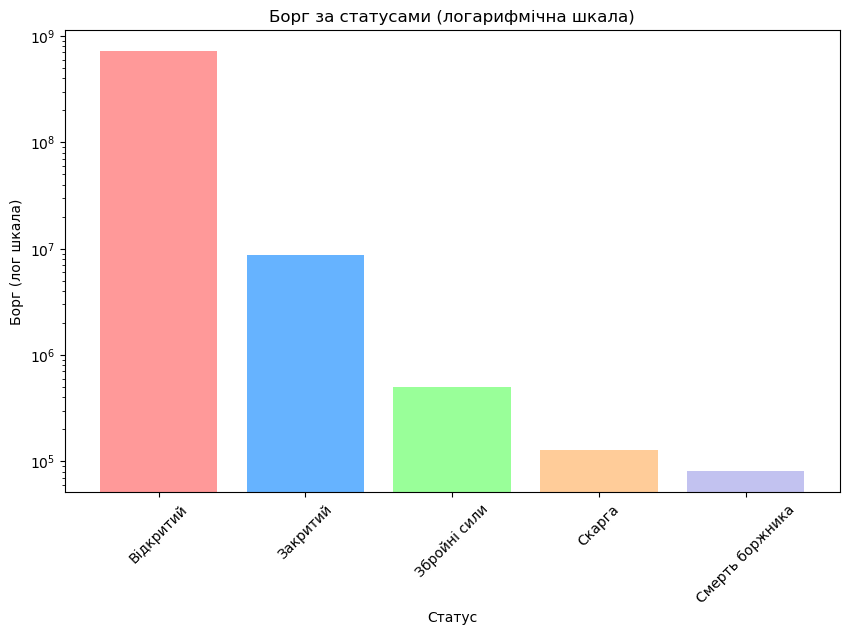

In [70]:
plt.figure(figsize=(10, 6))
plt.bar(debt_by_status.index, debt_by_status.values, 
        color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0'])
plt.yscale('log')  # Використання логарифмічної шкали
plt.xlabel("Статус")
plt.ylabel("Борг (лог шкала)")
plt.title("Борг за статусами (логарифмічна шкала)")
plt.xticks(rotation=45)
plt.show()

**Висновок:** загальна сума боргу становить 727,312,070 грн. Основна частка заборгованості припадає на відкриті справи (717,9 млн грн, 98,7%), тоді як закриті борги складають 8,7 млн грн (1,2%). Борги клієнтів зі статусами "Збройні сили", "Скарга" і "Смерть боржника" є незначними та становлять менше 0,2% загальної суми.

### 2. Який відсоток клієнтів не вніс жодного платежу?


In [74]:
total_clients = df.shape[0]
total_clients

229148

In [76]:
no_payment_clients = df[(df['Sum_First_Payment'].isna()) | (df['Sum_First_Payment'] == 0)].shape[0]

In [78]:
percentage_no_payment = (no_payment_clients / total_clients) * 100
print(f"Відсоток клієнтів, які не внесли жодного платежу: {percentage_no_payment:.2f}%")

Відсоток клієнтів, які не внесли жодного платежу: 96.97%


**Висновок:** з отриманого результату ми бачимо, на скільки ефективно здійснюється робота з боржниками, також можемо зрозуміти на скільки "тяжкий" борговий портфель.

### 3. Як розподілені боржники із відсутнім номером телефону за філіями провайдера у відсотках? Який середній відсоток боржників із відсутнім нт?

In [82]:
missing_nt_counts = df[df["Active"] == "відсутній нт"]["Branch_Letter"].value_counts()
all_branches = df["Branch_Letter"].unique()
missing_nt_counts = missing_nt_counts.reindex(all_branches, fill_value=0).sort_index()

total_counts = df["Branch_Letter"].value_counts().sort_index()

percentage_missing_nt = (missing_nt_counts / total_counts * 100).round(2)
percentage_missing_nt.name = "Відсоток боржників із відсутнім НТ (%)"

print("Відсоток боржників із відсутнім НТ за філіями (Branch_Letter):")
print(percentage_missing_nt)

Відсоток боржників із відсутнім НТ за філіями (Branch_Letter):
Branch_Letter
A   24.37
B   19.85
C   16.06
D   21.30
E   46.27
F   27.12
G   24.92
H   16.41
I   20.54
J   27.23
K   76.91
L   24.52
M   27.65
N   38.39
O   33.86
P   34.57
Name: Відсоток боржників із відсутнім НТ (%), dtype: float64


In [84]:
# Середній відсоток по всіх філіях
average_percentage = percentage_missing_nt.mean().round(2)
print(f"Середній відсоток боржників із відсутнім нт по всіх філіях: {average_percentage}%")

Середній відсоток боржників із відсутнім нт по всіх філіях: 30.0%


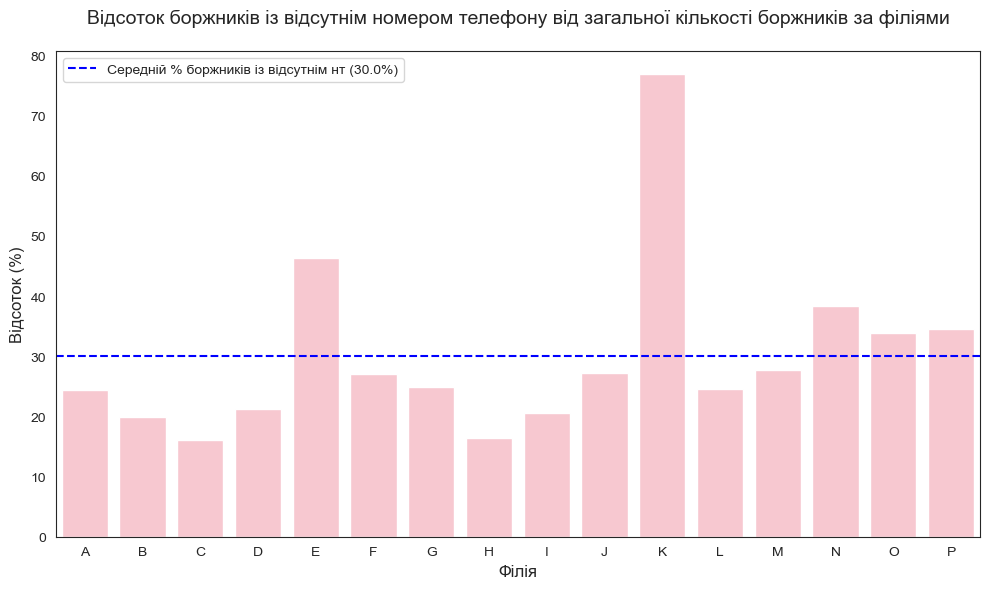

In [86]:
sns.set_style("white")
plt.figure(figsize=(10, 6))

sns.barplot(x=percentage_missing_nt.index, y=percentage_missing_nt.values, color='pink')

plt.axhline(y=average_percentage, color='blue', linestyle='--', label=f'Середній % боржників із відсутнім нт ({average_percentage}%)')

plt.title("Відсоток боржників із відсутнім номером телефону від загальної кількості боржників за філіями", fontsize=14, pad=20)
plt.xlabel("Філія", fontsize=12)
plt.ylabel("Відсоток (%)", fontsize=12)
plt.xticks(rotation=0)
plt.legend()

plt.tight_layout()
plt.show()

**Висновок:** аналіз отриманих результатів показує, що середній відсоток боржників із відсутнім НТ по всіх філіях становить 30%. Динаміка цього показника є загалом рівномірною серед філій провайдера. Виняток становлять філії E, K, N, O, P, де відсоток боржників перевищує середнє значення. Це свідчить про необхідність детальнішого аналізу причин відхилень у зазначених філіях.

### 4. Визначити, як розподілений борг для кожної компанії залежно від статусу боржника за сумою боргового портфеля?

In [90]:
pivot_table = df.pivot_table(
    values="Debt", 
    index="Company", 
    columns="Active", 
    aggfunc="sum", 
    fill_value=0
)
print(pivot_table)

Active     активний нт  відсутній нт  неактивний нт
Company                                            
БКС     223,059,367.23 84,356,376.74  63,965,492.34
УКА     263,359,459.92 62,490,870.76  30,080,503.02


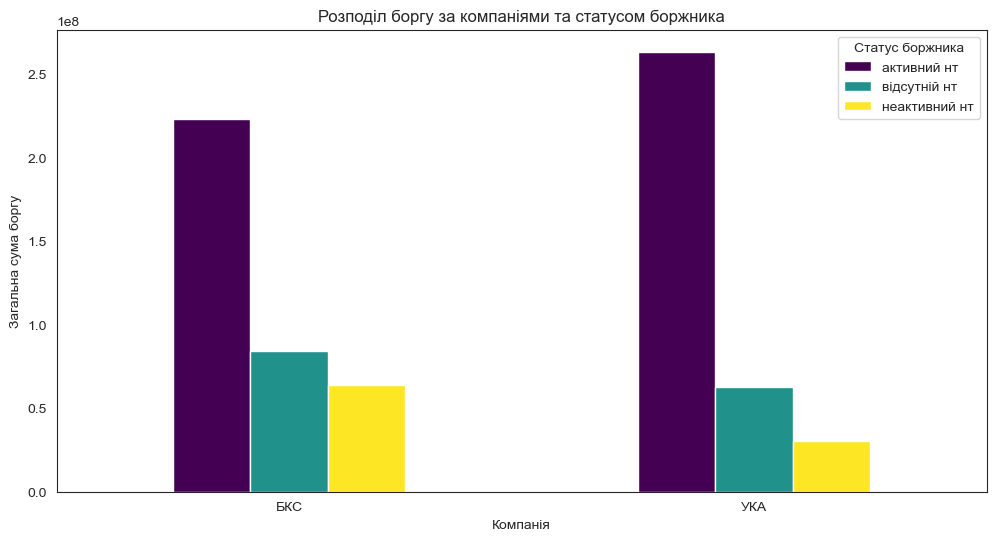

In [92]:
pivot_table.plot(kind="bar", figsize = (12, 6), colormap = "viridis")

plt.title("Розподіл боргу за компаніями та статусом боржника")
plt.xlabel("Компанія")
plt.ylabel("Загальна сума боргу")
plt.xticks(rotation=0)
plt.legend(title="Статус боржника")
plt.show()

**Висновок:** аналіз розподілу боргу за статусом боржників показує, що в компанії "УКА" переважають боржники з активним нт. Борг боржників із відсутнім нт і неактивним нт у "БКС" значно більший, ніж в "УКА". Для зменшення ризиків стягнення "УКА" варто приділити увагу боржникам із активним нт, а "БКС" — боржникам із відсутнім і неактивним нт .

### 5. Визначити, як розділені боржники за їх статусами між компаніями у відсотках?

<Figure size 1200x600 with 0 Axes>

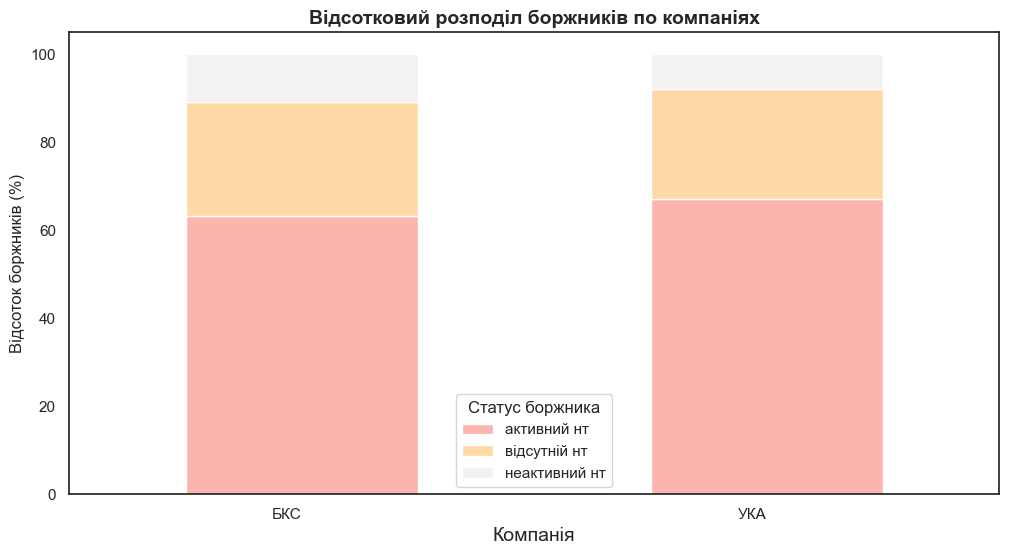

In [96]:
sns.set_theme(style = "white")

pivot_table = df.pivot_table(
    values = "Debt",  
    index = "Company", 
    columns = "Active", 
    aggfunc = "count",  # Рахуємо кількість боржників
    fill_value = 0
)
# Розраховуємо відсотковий розподіл боржників для кожної компанії
percent_distribution = pivot_table.div(pivot_table.sum(axis = 1), axis = 0) * 100

# Побудова графіка (накопичена стовпчаста діаграма)
plt.figure(figsize = (12, 6))
percent_distribution.plot(
    kind = "bar", 
    stacked = True, 
    colormap = "Pastel1",
    figsize = (12, 6)
)

plt.title("Відсотковий розподіл боржників по компаніях", fontsize = 14, fontweight = "bold")
plt.xlabel("Компанія", fontsize = 14)
plt.ylabel("Відсоток боржників (%)", fontsize=12)
plt.legend(title = "Статус боржника")

plt.xticks(rotation=0, ha="right")
plt.show()

**Висновок:** з отриманого результату ми бачимо, що розподіл боржників за їх статусом по компаніям є рівномірним, без великих відхилень, можна сказати, що по цьому критерію обидві компанії знаходяться в рівних умовах .

### 6. Які загальні суми платежів виконали компанії?

Загальна сума платежів та їх відсотковий розподіл:
         total_payment  percentage
Company                           
БКС       4,509,909.42       60.28
УКА       2,971,866.17       39.72


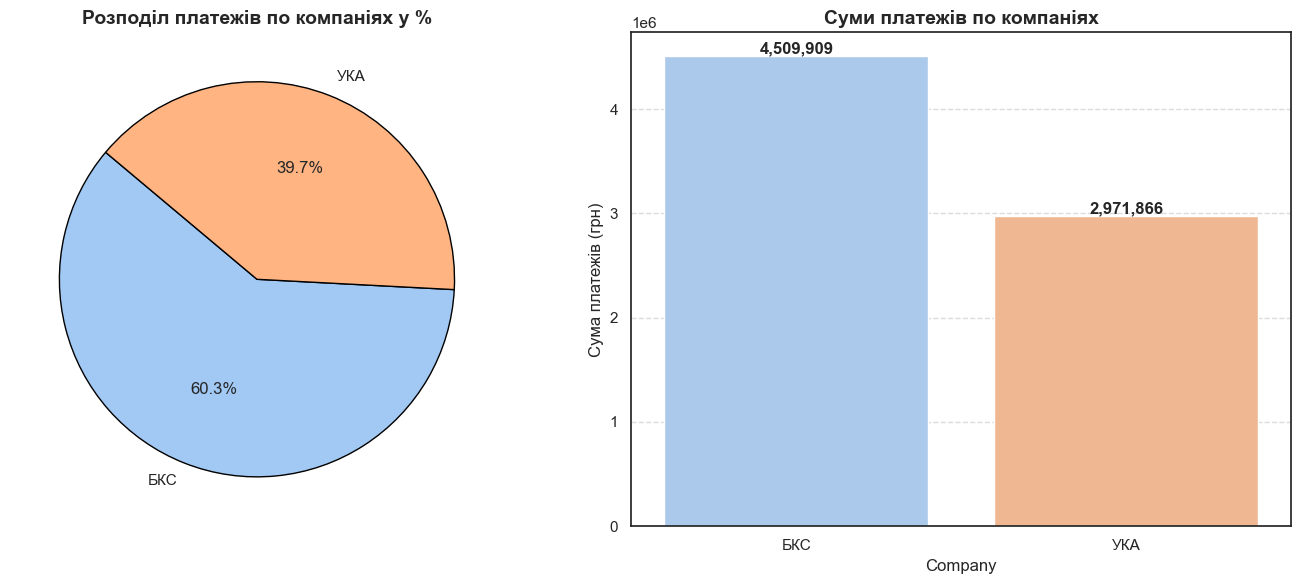

In [100]:
df_summary = df.groupby("Company").agg(
    total_payment=("Sum_First_Payment", "sum")
).round(2)

df_summary["percentage"] = (df_summary["total_payment"] / df_summary["total_payment"].sum()) * 100

print("Загальна сума платежів та їх відсотковий розподіл:")
print(df_summary)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = sns.color_palette("pastel")
axes[0].pie(
    df_summary["total_payment"], 
    labels=df_summary.index, 
    autopct="%1.1f%%",  
    colors=colors, 
    startangle=140, 
    wedgeprops={"edgecolor": "black"}
)
axes[0].set_title("Розподіл платежів по компаніях у %", fontsize=14, fontweight="bold")

sns.barplot(
    x=df_summary.index, 
    y=df_summary["total_payment"], 
    palette="pastel", 
    ax=axes[1]
)

for p in axes[1].patches:
    axes[1].annotate(f"{p.get_height():,.0f}", 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha="center", va="bottom", fontsize=12, fontweight="bold")

axes[1].set_title("Суми платежів по компаніях", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Сума платежів (грн)", fontsize=12)
axes[1].set_xticklabels(df_summary.index, rotation=0)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Висновок:** компанія БКС зібрала найбільшу суму платежів – 4,51 млн грн, що становить 60,28% від загального обсягу. Натомість компанія УКА зібрала 2,97 млн грн (39,72%). Це свідчить про те, що БКС має вищий фінансовий потік у цьому сегменті.

### 7. Виконайте розрахунок середнього платежу по всьому портфелю та окремо по компаніях БКС і УКА

Середній платіж по компаніях та загалом:
         avg_payment
Company             
БКС            37.41
УКА            27.36
Загалом        32.65


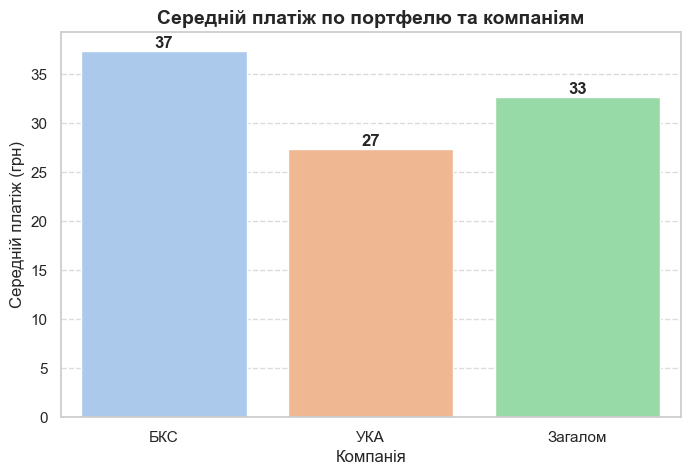

In [104]:
sns.set_theme(style="whitegrid")

df_avg_payment = df.groupby("Company").agg(
    avg_payment=("Sum_First_Payment", "mean")
).round(2)

df_avg_payment.loc["Загалом"] = df["Sum_First_Payment"].mean().round(2)

print("Середній платіж по компаніях та загалом:")
print(df_avg_payment)

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=df_avg_payment.index, 
    y=df_avg_payment["avg_payment"], 
    palette="pastel"
)

plt.title("Середній платіж по портфелю та компаніям", fontsize=14, fontweight="bold")
plt.xlabel("Компанія", fontsize=12)
plt.ylabel("Середній платіж (грн)", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f"{p.get_height():,.0f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", va="bottom", fontsize=12, fontweight="bold")

plt.show()

**Висновок:** середній платіж у компанії "БКС" становить 37,41 грн, що вище, ніж у "УКА" (27,36 грн). Загалом середній платіж по портфелю складає 32,65 грн. Це може свідчити як про вищу платоспроможність клієнтів БКС, так і про ефективнішу роботу компанії з боржниками.

### 8. Динаміка платежів по компаніям за часом.

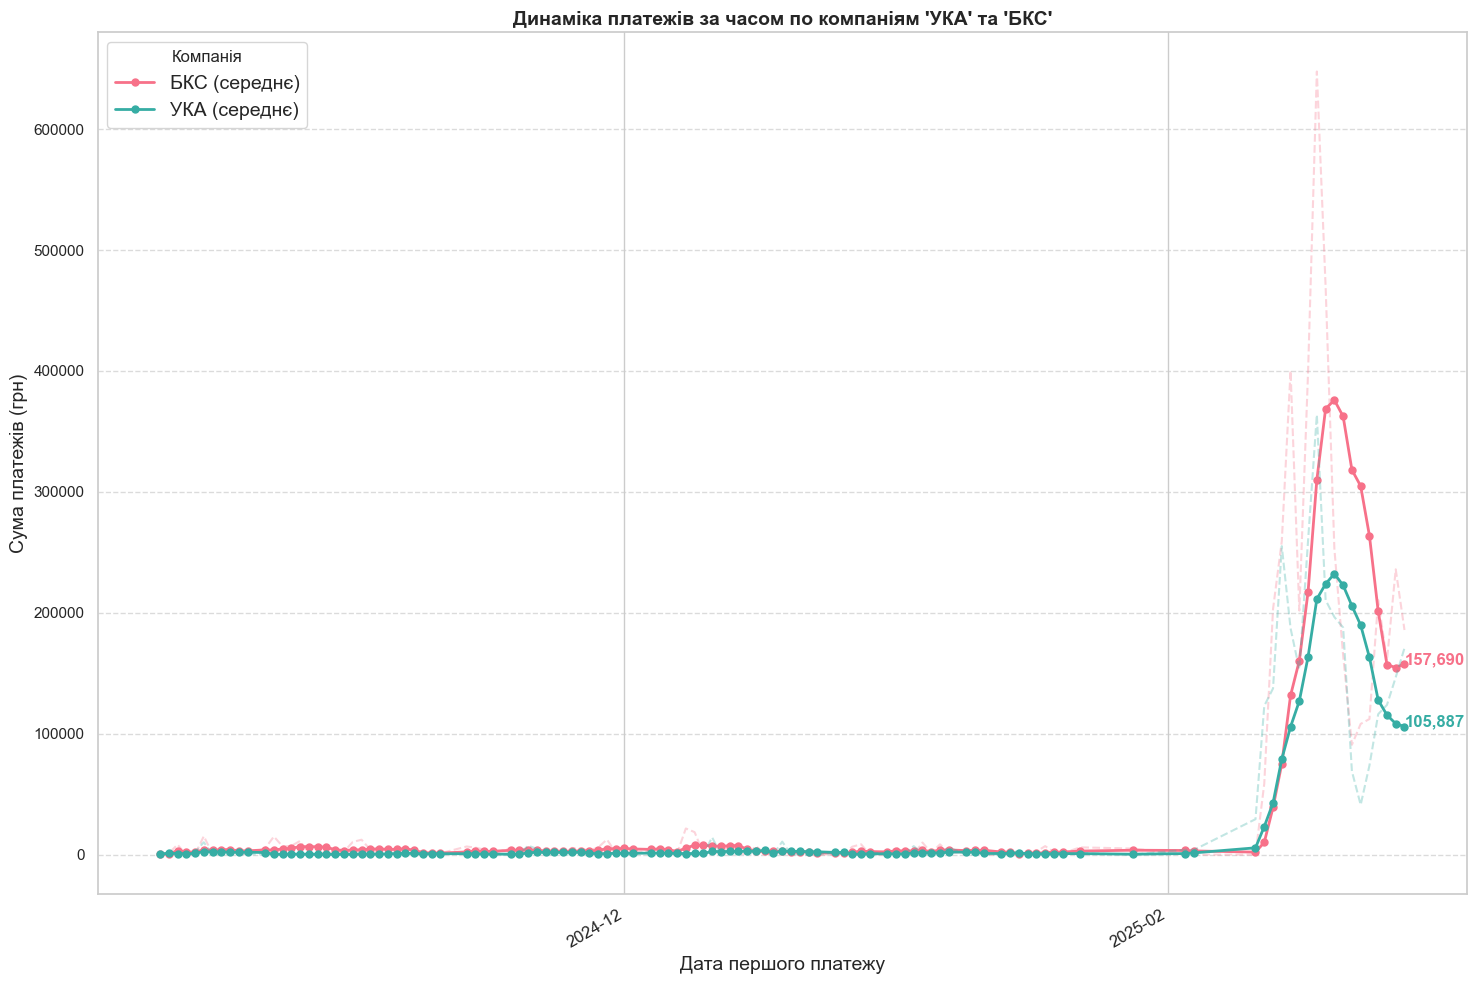

In [108]:
df_filtered = df[df["Company"].isin(["УКА", "БКС"])]

payments_by_date_company = df_filtered.groupby(["Date_First_Payment", "Company"])["Sum_First_Payment"].sum().unstack()

payments_smoothed = payments_by_date_company.rolling(window=7, min_periods=1).mean()

sns.set_theme(style="whitegrid")  

plt.figure(figsize=(15, 10))

colors = sns.color_palette("husl", n_colors=len(payments_by_date_company.columns))

for i, company in enumerate(payments_by_date_company.columns):
    plt.plot(payments_by_date_company.index, payments_by_date_company[company], 
             linestyle="--", alpha=0.3, color=colors[i])  # Оригінальні дані (пунктиром)
    plt.plot(payments_smoothed.index, payments_smoothed[company], 
             marker="o", linestyle="-", linewidth=2, markersize=5, 
             color=colors[i], label=f"{company} (середнє)")
    
    last_value = payments_smoothed[company].dropna().iloc[-1]  
    last_date = payments_smoothed.index[-1]  
    plt.text(last_date, last_value, f"{last_value:,.0f}", 
             color=colors[i], fontsize=12, fontweight="bold")

plt.xticks(rotation=30, ha="right", fontsize=12)  
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.title("Динаміка платежів за часом по компаніям 'УКА' та 'БКС'", fontsize=14, fontweight="bold")
plt.xlabel("Дата першого платежу", fontsize=14)
plt.ylabel("Сума платежів (грн)", fontsize=14)

plt.legend(title="Компанія", fontsize=14, loc="upper left")

plt.tight_layout()
plt.show()

**Висновок:** динаміка платежів показує різкий стрибок у лютому 2025 року, після чого спостерігається зниження, але з певними коливаннями. Компанія "БКС" має вищі пікові значення, що може свідчити про ефективнішу роботу з боржниками або кращу платоспроможність клієнтів. Водночас обидві компанії демонструють схожий тренд зростання та спадання платежів.

### 9. Який середній та медіанний час від першого контакту до першого платежу

Статистика за часом платежу після першого контакту:
count   1,306.00
mean        5.62
std        11.30
min         0.00
25%         1.00
50%         2.00
75%         6.00
max       100.00
Name: Days_to_Pay, dtype: float64


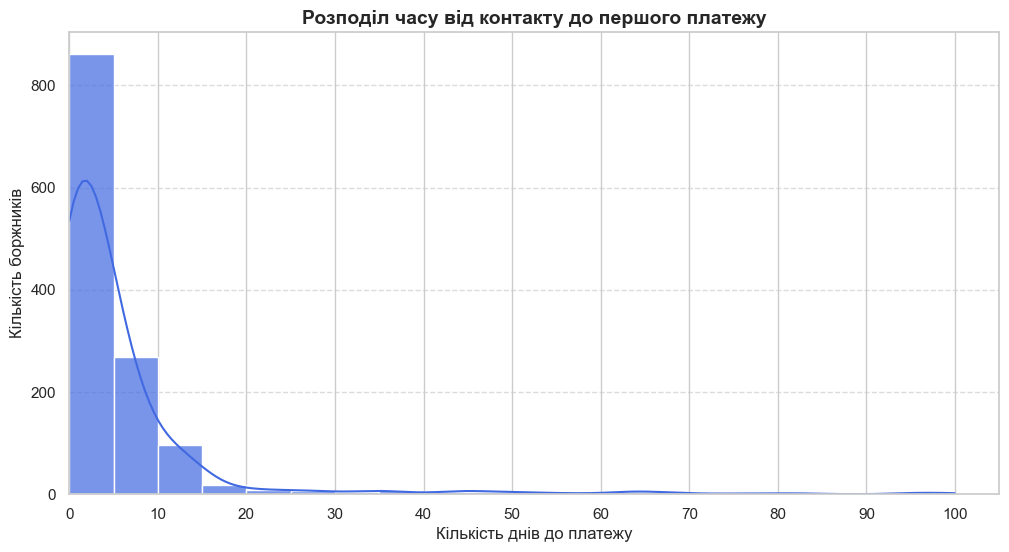

In [112]:
df["Days_to_Pay"] = (df["Date_First_Payment"] - df["Date_First_Contact"]).dt.days

df_filtered = df[df["Days_to_Pay"] >= 0]

max_days = df_filtered["Days_to_Pay"].max()

days_summary = df_filtered["Days_to_Pay"].describe().round(2)
print("Статистика за часом платежу після першого контакту:")
print(days_summary)

plt.figure(figsize=(12, 6))
sns.histplot(df_filtered["Days_to_Pay"], 
             bins=np.arange(0, max_days + 5, 5),  # Крок бінів = 5 днів
             kde=True, color="royalblue", alpha=0.7)

plt.xlim(0, max_days + 5)
plt.xticks(np.arange(0, max_days + 5, step=10))

plt.title("Розподіл часу від контакту до першого платежу", fontsize=14, fontweight="bold")
plt.xlabel("Кількість днів до платежу", fontsize=12)
plt.ylabel("Кількість боржників", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

**Висновок:** медіана показує, що 50% боржників здійснюють платіж протягом 2 днів після першого контакту. 75% платежів надходять протягом 6 днів, однак максимальний термін сплати досягає 100 днів, що свідчить про значні коливання у поведінці боржників. Середній час сплати становить 5,62 дні із високою дисперсією (std = 11,3), що вказує на наявність групи боржників із суттєвими затримками платежів.

### 10. Який канал комунікації найбільше впливає на отримання обіцянки платежу та фактичну першу оплату боргу?

In [116]:
df_corr = df.assign(
    received_contact=df["Date_First_Contact"].notna(),
    received_sms=df["Date_First_SMS"].notna(),
    answered_ivr=df["Date_First_Answered_Ivr"].notna(),
    gave_ptp=df["Date_First_PTP"].notna(),
    made_payment=df["Date_First_Payment"].notna()
)

correlation_matrix = df_corr[["received_contact", "received_sms", "answered_ivr", "gave_ptp", "made_payment", "Sum_PTP", "Sum_First_Payment"]].corr()
print(correlation_matrix)

                   received_contact  received_sms  answered_ivr  gave_ptp  \
received_contact               1.00          0.19          0.37      0.40   
received_sms                   0.19          1.00          0.27      0.05   
answered_ivr                   0.37          0.27          1.00      0.17   
gave_ptp                       0.40          0.05          0.17      1.00   
made_payment                   0.16          0.04          0.18      0.21   
Sum_PTP                        0.25          0.06          0.09      0.61   
Sum_First_Payment              0.09          0.05          0.09      0.13   

                   made_payment  Sum_PTP  Sum_First_Payment  
received_contact           0.16     0.25               0.09  
received_sms               0.04     0.06               0.05  
answered_ivr               0.18     0.09               0.09  
gave_ptp                   0.21     0.61               0.13  
made_payment               1.00     0.12               0.50  
Sum_PTP    

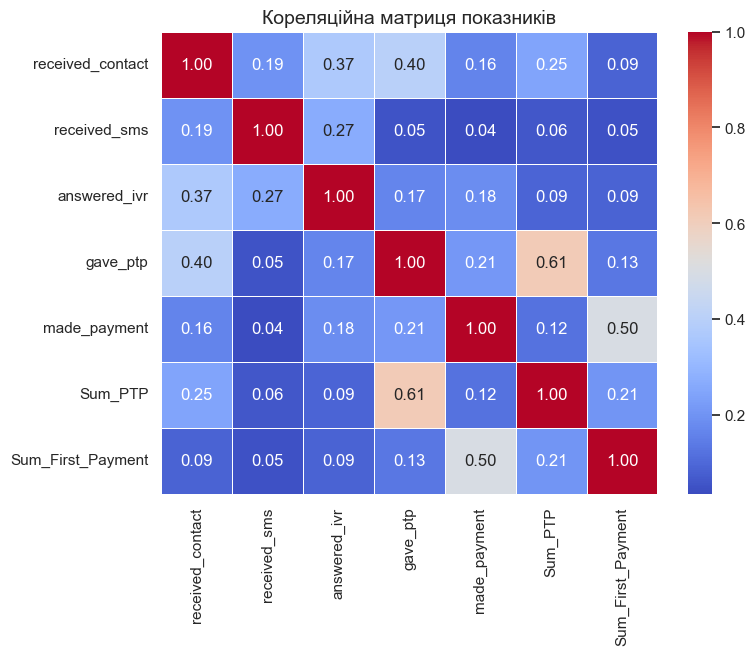

In [118]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Кореляційна матриця показників", fontsize=14)

plt.show()

**Висновок:** кореляційний аналіз показує, що наявність контакту з боржником (received_contact) має помірний зв’язок із наданням обіцянки платежу (gave_ptp, 0.40) та здійсненням платежу (made_payment, 0.16). Найсильніша кореляція спостерігається між сумою обіцяних платежів (Sum_PTP) і кількістю обіцянок (gave_ptp, 0.61), що логічно. Проте загальна кореляція між контактними діями та фактичними платежами є слабкою, що може свідчити про необхідність удосконалення стратегії комунікації з боржниками.

## 11. Як відрізняються філії за сумою платежів?

In [122]:
branch_summary = df.groupby("Branch_Letter")["Sum_First_Payment"].sum().sort_values(ascending=False)
print(branch_summary)

Branch_Letter
J   2,908,332.09
C   1,749,132.91
A     471,315.98
D     426,201.62
L     258,653.08
G     252,204.53
N     249,296.06
B     230,602.01
O     195,177.39
E     170,291.49
P     152,145.73
H     129,351.53
I     116,860.13
F     111,360.67
M      60,850.37
K           0.00
Name: Sum_First_Payment, dtype: float64


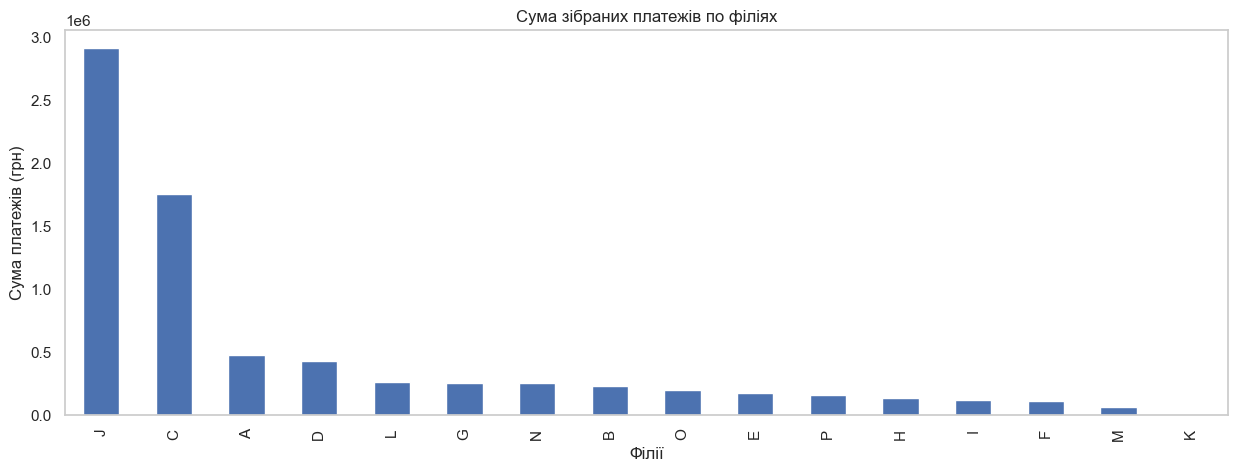

In [124]:
branch_summary.plot(kind='bar', figsize=(15, 5))
plt.title("Сума зібраних платежів по філіях")
plt.ylabel("Сума платежів (грн)")
plt.xlabel("Філії")
plt.grid(False)
plt.show()

**Висновок:** філія "J" є беззаперечним лідером по платежам (2,9 млн грн), суттєво випереджаючи інші, тоді як "C" (1,7 млн грн) та "A" (471 тис. грн) також демонструють високі результати. Найменші суми платежів у філій "M" (60 тис. грн) та "F" (111 тис. грн), що може свідчити про менш ефективну роботу, а "K" взагалі не має жодних надходжень (0 грн), що потребує окремого аналізу.